# Summary


---
# Setup


In [1]:
# imports
import os

import numpy as np
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from scipy import stats

from popy.config import COLORS, PROJECT_PATH_LOCAL

In [2]:
# helper functions
plt.rcParams.update({'font.size': 8})

def plot_RL_vs_forage_single_sess_horizontal(ax=None, data=None, x_col=None, y_col=None, title=None, session_col='session', paper_format=False):
    """Create R-style plot with box and jittered points (horizontal version)
    
    Args:
        ax: matplotlib axis
        data: DataFrame with the data
        x_col: column name for x-axis categories (now on y-axis)
        y_col: column name for values (now on x-axis)
        title: plot title
        session_col: column name for session identifier
    """
    palette = COLORS
    axis = ax
    if paper_format:
        fontsize = 8
        h = 2 
        w = 2
        s = 15
    else:
        fontsize = 18

        h = 3
        w = 4
        s = 10

    if axis is None:
        fig, ax = plt.subplots(1, 1, figsize=(w, h))

    data = data.copy().sort_values(by=x_col)
    categories = data[x_col].unique()
    y_positions = [0, .5]
    
    x_offset = .4
    lw = .4 
        
    # Create boxplots (horizontal)
    box_data = [data.loc[data[x_col] == cat, y_col].values for cat in categories]
    bp = ax.boxplot(box_data, positions=y_positions, widths=0.5, patch_artist=True,
                    boxprops=dict(alpha=0.7),
                    showfliers=False,
                    medianprops=dict(color='black'),
                    flierprops=dict(markersize=3, alpha=0.5),
                    vert=False)  # <-- horizontal

    # Color the boxes
    colors = [palette[cat] for cat in categories]
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # Store jitter positions
    jitter_positions = {}
    # If color is a string like 'red' or hex '#ff0000'
    base_rgba = mcolors.to_rgba(color, alpha=.5)
    # Darken by mixing with black (multiply RGB values by 0.7 to make it darker)
    edge_color = (base_rgba[0] * 0.7, base_rgba[1] * 0.7, base_rgba[2] * 0.7, 1.0)

    # Add jittered points (horizontal scatter)
    for i, cat in enumerate(categories):
        x_data = data.loc[data[x_col] == cat, y_col].values
        # If color is a string like 'red' or hex '#ff0000'
        base_rgba = mcolors.to_rgba(palette[cat], alpha=.5)
        # Darken by mixing with black (multiply RGB values by 0.7 to make it darker)
        edge_color = (base_rgba[0] * 0.7, base_rgba[1] * 0.7, base_rgba[2] * 0.7, 1.0)
        y_jitter = np.random.normal(-1, 0.15, size=len(x_data))
        
        # Generate random zorder values for each point
        zorder_values = np.random.uniform(10, 1000, size=len(x_data))
        
        # Plot each point individually with its own random zorder
        for x_val, y_val, z_val in zip(x_data, y_jitter, zorder_values):
            scatter = ax.scatter(x_val, y_val, s=s, facecolors=base_rgba, edgecolors=edge_color, linewidth=.5, zorder=z_val)

        if session_col is not None:
            session_data = data.loc[data[x_col] == cat, session_col].values
            jitter_positions[cat] = dict(zip(session_data, zip(x_data, y_jitter)))

    # Significance test
    if len(categories) == 2:
        group1_data = data.loc[data[x_col] == categories[0], y_col]
        group2_data = data.loc[data[x_col] == categories[1], y_col]
        _, p_value = stats.mannwhitneyu(group1_data, group2_data, alternative='two-sided')

        # Calculate mean positions for significance line
        mean1 = group1_data.mean()
        mean2 = group2_data.mean()
        
        # Get y positions for the categories
        y1 = y_positions[0]
        y2 = y_positions[1]
        
        # Position significance line above the plots
        line_height = max(y_positions) + 0.8
        
        if p_value < 0.001:
            significance = '***'
        elif p_value < 0.01:
            significance = '**'
        elif p_value < 0.05:
            significance = '*'
        else:
            significance = 'n.s.'

        # Add horizontal significance line spanning between box means
        ax.plot([mean1, mean2], [line_height, line_height], '-k', lw=2*lw)
        # Add vertical lines connecting to boxes
        ax.plot([mean1, mean1], [line_height - 0.1, line_height], '-k', lw=2*lw)
        ax.plot([mean2, mean2], [line_height - 0.1, line_height], '-k', lw=2*lw)
        # Add significance text at the center
        ax.text((mean1 + mean2) / 2, line_height + 0.05, f'{significance} (n={len(group1_data)})',
                va='bottom', ha='center', fontsize=fontsize)

    # Formatting
    ax.axhline(-1, linestyle='-', alpha=1, color='black', lw=4*lw, zorder=1)

    vline_bottom = min(y_positions) - 1
    vline_top = max(y_positions) + 0.5  # stay below significance line
    ax.vlines(0, vline_bottom, vline_top, linestyle='-', color='black', lw=1, zorder=0)

    ax.set_yticks([])
    ax.set_xlabel('Change in neural value \n$\Delta V = V_t - V_{t-1}$', fontsize=fontsize)
    ax.tick_params(axis='x', length=0)  # Remove x tick markers, keep labels

    ax.set_ylabel('')

    ax.set_title(title, fontsize=fontsize)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(axis='x', linestyle='--', alpha=0.5, zorder=0)

    if axis is None:
        return fig, ax
    else:
        return ax

def create_2d_scatter_with_marginals(data, x_type='within', y_type='alter', 
                                   session_col='session', feedback_col='feedback',
                                   value_col='dV_neural', title=None, palette=None,
                                paper_format=False):
    """
    Create a 2D scatter plot with marginal distributions
    
    Args:
        data: DataFrame with the data
        x_type: type value for x-axis (e.g., 'within')
        y_type: type value for y-axis (e.g., 'alter')
        session_col: column name for session identifier
        feedback_col: column name for feedback (0/1)
        value_col: column name for the neural values
        title: plot title
        palette: color palette dict
        figsize: figure size
        paper_format: whether to use paper formatting
    """
    
    if palette is None:
        palette = {'0': 'tab:red', '1': 'tab:green'}
    
    if paper_format:
        plt.rcParams.update({'font.size': 8})
        s = 15
        h = 2.5 * 5.3/6
        w = 2.5 * 5.3/6
        lw = 0.4
    else:
        plt.rcParams.update({'font.size': 12})
        s = 30
        lw = 0.8
        h, w = 6, 6

    # Trick: if signif is not a column, add all trues
    if 'signif' not in data.columns:
        data['signif'] = True

    # Prepare data for scatter plot
    # Get x-axis data (e.g., within target)
    x_data = data[data['type'] == x_type].copy()
    # Get y-axis data (e.g., alter target) 
    y_data = data[data['type'] == y_type].copy()
    
    # Create scatter data by merging on session and feedback
    scatter_data = []
    
    count_all, count_within_signif, count_within_alter_signif = 0, 0, 0
    for session in data[session_col].unique():
        count_all += 1
        signif_same = x_data[(x_data[session_col] == session) & (x_data[feedback_col] == 1)]['signif'].values[0]
        signif_alter = y_data[(y_data[session_col] == session) & (y_data[feedback_col] == 1)]['signif'].values[0]
        for feedback in data[feedback_col].unique():
            x_val = x_data[(x_data[session_col] == session) & 
                          (x_data[feedback_col] == feedback)][value_col].values
            y_val = y_data[(y_data[session_col] == session) & 
                          (y_data[feedback_col] == feedback)][value_col].values
            
            if len(x_val) > 0 and len(y_val) > 0:
                scatter_data.append({
                    'x': x_val[0],
                    'y': y_val[0], 
                    'feedback': str(feedback),
                    'session': session,
                    'signif_same': signif_same,
                    'signif_alter': signif_alter
                })
    
    scatter_df = pd.DataFrame(scatter_data)

    # Create figure with gridspec for marginal plots
    fig = plt.figure(figsize=(w, h))
    
    # Define the grid: main plot, top histogram, right histogram
    gs = fig.add_gridspec(3, 3, 
                         width_ratios=[1, 4, 1], 
                         height_ratios=[1, 4, 1],
                         hspace=0.05, wspace=0.05)
    
    # Main scatter plot
    ax_main = fig.add_subplot(gs[1, 1])
    
    # Marginal plots
    ax_top = fig.add_subplot(gs[0, 1], sharex=ax_main)
    ax_right = fig.add_subplot(gs[1, 2], sharey=ax_main)
    
    # Create scatter plot
    for feedback in ['0', '1']:
        for signif_same in [True, False]:
            for signif_alter in [True, False]:
                # Filter data for this feedback and significance
                mask = (scatter_df['feedback'] == feedback) & \
                       (scatter_df['signif_same'] == signif_same) & \
                       (scatter_df['signif_alter'] == signif_alter)
                
                if mask.sum() > 0:
                    if signif_same is False:
                        ax_main.scatter(scatter_df.loc[mask, 'x'], 
                                   scatter_df.loc[mask, 'y'],
                                   c='black',
                                   alpha=0.3, 
                                   linewidths=lw*2,
                                   s=s/2,
                                   marker='x',
                                   zorder=0,
                                   )
                    else:
                        ax_main.scatter(scatter_df.loc[mask, 'x'], 
                                   scatter_df.loc[mask, 'y'],
                                   c=palette[feedback] if signif_alter else 'white',
                                   alpha=0.7, 
                                   s=s,
                                   edgecolor='black' if signif_alter else palette[feedback], 
                                   linewidth=lw,
                                   label=f'{"Unrewarded" if feedback == "0" else "Rewarded"}',
                                   zorder=10)
        
    
    # Add connecting lines between paired points (same session)
    if session_col == 'session':
        for session in scatter_df['session'].unique():
            session_data = scatter_df[scatter_df['session'] == session]
            if len(session_data) == 2:  # Both feedback conditions present
                x_vals = session_data['x'].values
                y_vals = session_data['y'].values
                ax_main.plot(x_vals, y_vals, '-', color='gray', alpha=0.3, 
                            linewidth=lw, zorder=0)
    
    # Add diagonal reference line
    '''lims = [
        np.min([ax_main.get_xlim(), ax_main.get_ylim()]),
        np.max([ax_main.get_xlim(), ax_main.get_ylim()]),
    ]
    ax_main.plot(lims, lims, 'k--', alpha=0.5, zorder=0, linewidth=lw)'''
    
    # Add zero lines
    ax_main.axhline(0, linestyle='--', alpha=0.5, color='black', linewidth=lw, zorder=0)
    ax_main.axvline(0, linestyle='--', alpha=0.5, color='black', linewidth=lw, zorder=0)
    
    # Set labels
    ax_main.set_xlabel(f'Within-target change\nin neural value')
    ax_main.set_ylabel(f'Across-target change\nin neural value')
    #ax_main.legend(frameon=False)
    
    # Create marginal distributions (top - x-axis distribution)
    for fb_id, feedback in enumerate(['0', '1']):
        # X-axis marginal (top)
        x_feedback_data = x_data[x_data[feedback_col] == int(feedback)][value_col].values
        if len(x_feedback_data) > 0:
            # Violin plot
            #density = stats.gaussian_kde(x_feedback_data)
            x_range = np.linspace(x_feedback_data.min() - 0.1 * np.ptp(x_feedback_data),
                                 x_feedback_data.max() + 0.1 * np.ptp(x_feedback_data), 200)
            #density_values = density(x_range)
            #density_values = density_values / density_values.max() * 0.8
            
            #ax_top.fill_between(x_range, 0, density_values, 
            #                   color=palette[feedback], alpha=0.3, 
            #                   edgecolor='black', linewidth=lw)
    
            # Box plot
            bp = ax_top.boxplot([x_feedback_data], positions=[0.4-fb_id*.2], widths=0.2, 
                               patch_artist=True, vert=False,
                               boxprops=dict(alpha=0.7, facecolor=palette[feedback]),
                               showfliers=False, medianprops=dict(color='black'))
    
    # Calculate significance for X-axis marginal
    x_data_pos = x_data[x_data['feedback'] == 1][value_col].values
    x_data_neg = x_data[x_data['feedback'] == 0][value_col].values
    U_x, p_value_x = stats.mannwhitneyu(x_data_pos, x_data_neg, alternative='two-sided')
    
    # Add significance line and p-value for X-axis marginal (top)
    # Position line between the box plot centers
    x_pos_center = np.median(x_data_pos)  # Center of positive feedback data
    x_neg_center = np.median(x_data_neg)  # Center of negative feedback data
    y_line = 0.9  # Position of the line
    line_height = 0.05  # Height of the brackets
    
    # Draw horizontal line between the medians
    ax_top.plot([x_neg_center, x_pos_center], [y_line, y_line], 'k-', linewidth=lw)
    
    # Format p-value with significance stars and sample size
    n_total = len(x_data_pos) + len(x_data_neg)
    if p_value_x > 0.05:
        p_text_x = f'n.s.'
    elif p_value_x <= 0.001:
        p_text_x = f'***'
    elif p_value_x <= 0.01:
        p_text_x = f'**'
    elif p_value_x <= 0.05:
        p_text_x = f'*'
    
    ax_top.text((x_neg_center + x_pos_center) / 2, y_line * 1.1, p_text_x, 
                ha='center', va='bottom', fontsize=plt.rcParams['font.size']-1)
    
    # Y-axis marginal (right)
    for fb_id, feedback in enumerate(['0', '1']):
        y_feedback_data = y_data[y_data[feedback_col] == int(feedback)][value_col].values
        if len(y_feedback_data) > 0:
            # Violin plot
            density = stats.gaussian_kde(y_feedback_data)
            y_range = np.linspace(y_feedback_data.min() - 0.1 * np.ptp(y_feedback_data),
                                 y_feedback_data.max() + 0.1 * np.ptp(y_feedback_data), 200)
            density_values = density(y_range)
            density_values = density_values / density_values.max() * 0.8
            
            #ax_right.fill_betweenx(y_range, 0, density_values, 
            #                      color=palette[feedback], alpha=0.3, 
            #                      edgecolor='black', linewidth=lw)
            
            # Box plot
            bp = ax_right.boxplot([y_feedback_data], positions=[0.4-fb_id*.2], widths=0.2, 
                                 patch_artist=True, vert=True,
                                 boxprops=dict(alpha=0.7, facecolor=palette[feedback]),
                                 showfliers=False, medianprops=dict(color='black'))
    
    # Calculate significance for Y-axis marginal
    y_data_pos = y_data[y_data['feedback'] == 1][value_col].values
    y_data_neg = y_data[y_data['feedback'] == 0][value_col].values
    U_y, p_value_y = stats.mannwhitneyu(y_data_pos, y_data_neg, alternative='two-sided')

    # Add significance line and p-value for Y-axis marginal (right)
    # Position line between the box plot centers
    y_pos_center = np.median(y_data_pos)  # Center of positive feedback data
    y_neg_center = np.median(y_data_neg)  # Center of negative feedback data
    x_line = 0.9  # Position of the line
    line_width = 0.05  # Width of the brackets
    
    # Draw vertical line between the medians
    ax_right.plot([x_line, x_line], [y_neg_center, y_pos_center], 'k-', linewidth=lw)
    
    # Format p-value with significance stars and sample size
    if p_value_y > 0.05:
        p_text_y = f'n.s.'
    elif p_value_y <= 0.001:
        p_text_y = f'***'
    elif p_value_y <= 0.01:
        p_text_y = f'**'
    elif p_value_y <= 0.05:
        p_text_y = f'*'
    
    ax_right.text(x_line*1.3, (y_neg_center + y_pos_center) / 2, p_text_y, 
                  ha='center', va='center', rotation=90, fontsize=plt.rcParams['font.size']-1)
    
    # Add zero lines to marginal plots
    ax_top.axvline(0, linestyle='--', alpha=0.5, color='black', linewidth=lw, zorder=0)
    ax_right.axhline(0, linestyle='--', alpha=0.5, color='black', linewidth=lw, zorder=0)
    
    # Format marginal plots
    ax_top.set_xlim(ax_main.get_xlim())
    ax_top.set_ylim(0, 1)
    ax_top.set_yticks([])
    ax_top.spines['top'].set_visible(False)
    ax_top.spines['right'].set_visible(False)
    ax_top.spines['left'].set_visible(False)
    ax_top.tick_params(labelbottom=False)
    
    ax_right.set_ylim(ax_main.get_ylim())
    ax_right.set_xlim(0, 1)
    ax_right.set_xticks([])
    ax_right.spines['top'].set_visible(False)
    ax_right.spines['right'].set_visible(False)
    ax_right.spines['bottom'].set_visible(False)
    ax_right.tick_params(labelleft=False)
    
    # Format main plot
    ax_main.spines['top'].set_visible(False)
    ax_main.spines['right'].set_visible(False)
    
    n_total = len(np.unique(x_data['session']))  # Number of unique sessions
    plt.suptitle(f'n= {n_total}')

    return fig, ax_main, ax_top, ax_right

def get_data():
    path = os.path.join(PROJECT_PATH_LOCAL, 'data', 'results', 'behav_neural_value_across_target_normalized', 'behav.pkl')

    results_df = pd.read_pickle(path)
    # sort by monkey session trial_id target type
    results_df = results_df.sort_values(by=['monkey', 'session', 'subregion', 'trial_id'])
    results_df = results_df.dropna()
    return results_df

def merge_alter_values(results_df):
    """Merge 'alter' type rows by averaging their values for each trial, so that we only have one."""
    # for each (monkey, session, subregion, trial_id), replace the two 'type'=='alter' rows with one that has these attributes, and averages everything else

    results_df_within = results_df[results_df['type'] == 'within']
    results_df_alter = results_df[results_df['type'] == 'alter']

    results_df_alter_means = []
    for (monkey, session, subregion, trial_id), group in results_df_alter.groupby(['monkey', 'session', 'subregion', 'trial_id']):
        mean_row = {}
        mean_row['monkey'] = monkey
        mean_row['session'] = session
        mean_row['subregion'] = subregion
        mean_row['trial_id'] = trial_id
        mean_row['type'] = 'alter'
        mean_row['feedback'] = group['feedback'].values[0]  # or .mean() if you want the average
        mean_row['dV_neural'] = group['dV_neural'].mean()

        results_df_alter_means.append(mean_row)
    results_df_alter_means = pd.DataFrame(results_df_alter_means)

    # Combine the two dataframes
    results_df_combined = pd.concat([results_df_within[results_df_alter_means.columns.tolist()], results_df_alter_means], ignore_index=True)

    # feedback is int

    results_df = results_df_combined
    results_df = results_df.sort_values(by=['monkey', 'session', 'subregion', 'trial_id'])

    # reset index
    results_df = results_df.reset_index(drop=True)

    return results_df

def extract_mean_dVs(res):
    # get mean of trials (i.e. mean of all trials in a session) for each monkey, session, subregion, feedback, type
    results_df_mean = []
    for (monkey, session, subregion, type_, feedback), group in res.groupby(['monkey', 'session', 'subregion', 'type', 'feedback']):
        # get mean of dV_neural, drop trial_id
        row_to_add = {}
        row_to_add['monkey'] = monkey
        row_to_add['session'] = session
        row_to_add['subregion'] = subregion
        row_to_add['type'] = type_
        row_to_add['feedback'] = feedback
        row_to_add['dV_neural'] = group['dV_neural'].mean()
        row_to_add['signif'] = np.nan

        results_df_mean.append(row_to_add)
    # to df
    results_df_mean = pd.DataFrame(results_df_mean)

    for (monkey, session, subregion, type_), group in res.groupby(['monkey', 'session', 'subregion', 'type']):
        # compute significantce
        dVs_pos = group[(group['feedback'] == 1) & (group['type'] == type_)]['dV_neural'].values
        dVs_neg = group[(group['feedback'] == 0) & (group['type'] == type_)]['dV_neural'].values
        U, p_value = stats.mannwhitneyu(dVs_pos, dVs_neg, alternative='two-sided')

        # add True to the significant column for this type
        results_df_mean.loc[(results_df_mean['monkey'] == monkey) & 
                            (results_df_mean['session'] == session) & 
                            (results_df_mean['subregion'] == subregion) & 
                            (results_df_mean['type'] == type_), 'signif'] = p_value < 0.05
    return results_df_mean

---
# Get data

In [3]:
# Get data
res = get_data()
res = merge_alter_values(res)

# normalize dV_neural within each monkey, session, subregion
res[f'dV_neural'] = res.groupby(['monkey', 'session', 'subregion'])[f'dV_neural'].transform(lambda x: (x - x.mean()) / x.std())
res

,monkey,session,subregion,trial_id,type,feedback,dV_neural
0,ka,020622,MCC,0,within,1,1.678890
1,ka,020622,MCC,0,alter,1,1.457574
2,ka,020622,MCC,1,within,1,0.137874
3,ka,020622,MCC,1,alter,1,0.014145
4,ka,020622,MCC,2,within,0,-1.313408
...,...,...,...,...,...,...,...
5239,po,240921,dLPFC,414,alter,0,-0.054381
5240,po,240921,dLPFC,415,within,0,-4.327875
5241,po,240921,dLPFC,415,alter,0,-0.306499
5242,po,240921,dLPFC,416,within,1,3.319712


---
# Create plots


<Axes: title={'center': 'Alter target'}, xlabel='Change in neural value \n$\\Delta V = V_t - V_{t-1}$'>

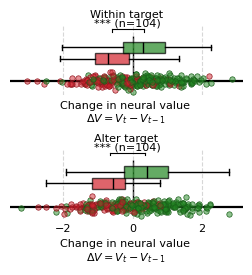

In [4]:
# Get example session
monkey, session, subregion = 'ka', '020622', 'MCC'
results_df_temp = res[(res['session'] == session) & (res['subregion'] == subregion) & (res['monkey'] == monkey)]


# Create the figure
fig, axs = plt.subplots(2, 1, figsize=(3, 2.5), sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': .8})

# Within target plot
plot_RL_vs_forage_single_sess_horizontal(axs[0],
                   results_df_temp.loc[results_df_temp['type'] == 'within'], 
                   'feedback', 'dV_neural', paper_format=True, title='Within target')

# Alter target plot
plot_RL_vs_forage_single_sess_horizontal(axs[1], 
                   results_df_temp.loc[results_df_temp['type'] == 'alter'],
                   'feedback', 'dV_neural', paper_format=True, title='Alter target')


## Plot session-wise

In [5]:
# extract session-per-session mean dVs for positive/negative feedback and for within/alter targets
results_df_mean = extract_mean_dVs(res)
results_df_mean

,monkey,session,subregion,type,feedback,dV_neural,signif
0,ka,020622,MCC,alter,0,-0.668127,True
1,ka,020622,MCC,alter,1,0.365865,True
2,ka,020622,MCC,within,0,-0.608413,True
3,ka,020622,MCC,within,1,0.329214,True
4,ka,020622,dLPFC,alter,0,-0.298918,True
5,ka,020622,dLPFC,alter,1,0.114170,True
6,ka,020622,dLPFC,within,0,-0.251900,True
7,ka,020622,dLPFC,within,1,0.185752,True
8,ka,210322,MCC,alter,0,-0.727890,True
9,ka,210322,MCC,alter,1,0.409287,True


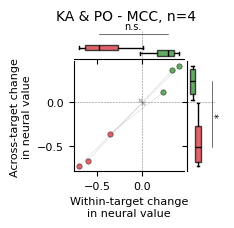

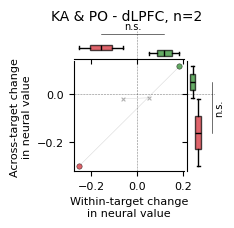

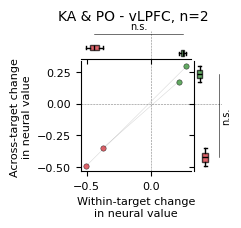

In [6]:
# Show results for each subregion
for subregion in results_df_mean['subregion'].unique():
    data = results_df_mean.loc[(results_df_mean['subregion'] == subregion)]
    fig, ax_main, ax_top, ax_right = create_2d_scatter_with_marginals(data, palette=COLORS, paper_format=True)
    fig.suptitle(f'KA & PO - {subregion}, n={len(np.unique(data.session))}', fontsize=10)